# Indeksacja. Prosta klasyfikacja obiektów.

## Cel ćwiczenia
- zapoznanie z dwuprzebiegowym algorytmem indeksacji (ang. *connected component labelling*):
- zapoznanie z prostą klasyfikacją obiektów z wykorzystaniem współczynników kształtu,
- zadanie domowe: zmodyfikowana indeksacja dwuprzebiegowa i indeksacja jednoprzebiegowa.

## Indeksacja

Większość dotychczas poznanych i wykorzystywanych algorytmów przetwarzania obrazu wykonywała operacje na całym obrazie (lub co najwyżej dokonywany był podział obiekt/obiekty - tło. Np. różne metody segmentacji).
Patrząc na poniższny rysunek człowiek widzi dwa kwadraty.

![Dwa kwadraty, obraz binarny](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/2objects.png)

Dla automatycznego systemu analizy i rozpoznawania obrazów przejście od etapu obiekty/tło do wyróżnienia dwóch kwadratów nie jest takie oczywiste i wymaga zastosowania jakieś formy indeksacji - czyli przypisania każdemu z pikseli uznanych za należące do obiektów (tu białych) jakieś etykiety (w naszym przypadku będą to dwie etykiety, ew. dodatkowa oznaczająca tło).

W tej części ćwiczenia zaprezentowany zostanie tzw. dwuprzebiegowy algorytm indeksacji (ang. *two-pass connected component labelling*).
Jego nazwa związana jest z koniecznością wykonania dwukrotnego odwiedzenia każdego z pikseli obrazu (dwie pętle/iteracje po obrazie).
Istnieją również tzw. jednoprzebiegowe algorytmy indeksacji.

## Opis algorytmu

- Na wejściu mamy obraz po binaryzacji - zakładamy, że piksele białe ('1', '255') należą do obiektów, tło jest czarne.

- W pierwszej iteracji obraz analizujemy linia po linii, od lewej do prawej, aż do napotkania pierwszego piksela o wartości różnej od '0'.
  W tej sytuacji dokonujemy analizy otoczenia piksela:

  ![Dwa kwadraty, obraz binarny](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclContext.png)

  gdzie: **X**  rozważany piksel, **A,B,C,D** - sąsiedzi z otoczenia.
  Uwaga. W przykładzie pokazano tzw. sąsiedztwo 8-elementowe.
  Niekiedy stosuje się również wersję 4-elementową (praktycznie bardzo rzadko).
  Wtedy analizie podlegałyby by tylko piksele **B** i **D**.

- Możliwe są następujące przypadki dla otoczenia __A,B,C,D__:
    - (a) wszystkie należą do tła __A,B,C,D == 0__.
      Wtedy znaleziony piksel __X__ należy do nowego obiektu - nadajemy mu zatem etykietę __X = L+1__ - przez __L__ rozumiemy poprzednią etykietę.
	  Uwaga. Przed uruchomieniem algorytmu __L__ należy zainicjować wartością  '1'
    - (b) jeden lub więcej pikseli ma przypisaną aktualną etykietę **L**.
	  Wtedy rozważanemu pikselowi przypisujemy etykietę **X = L**.
    - (c) w otoczeniu występują piksele o różnych etykietach np. *L1* i *L2*.
	  Wtedy przyjmuje się zasadę, że rozważanemu pikselowi *X* przypisuje się mniejszą z wartości *L1* i *L2* (*X = min(L1,L2)*).

## Implementacja:

- Wczytaj obraz *ccl1.png*, wyświetl go.
  Po krótkiej analizie można zauważyć, że występuje na nim 7 odrębnych obiektów.
      Ich ``wykrycie'' będzie naszym celem.

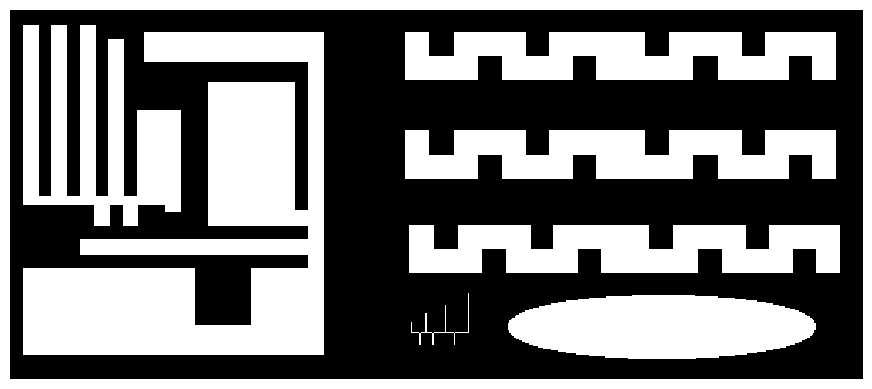

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

URL = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/"

CCL_FILENAME = "ccl1.png"
SHAPES_FILENAME = "shapes.png"
SHAPES_REAL_FILENAME = "shapesReal.png"

for filename in [CCL_FILENAME, SHAPES_FILENAME, SHAPES_REAL_FILENAME]:
    if not os.path.exists(filename):
        r = requests.get(URL + filename, allow_redirects=True)
        open(filename, "wb").write(r.content)


def show_grayscale_image(ax, image, title=None, matshow=False, cmap="gray"):
    interpolation = "none" if matshow else "antialiased"
    ax.axis("off")

    ax.imshow(image, cmap, interpolation=interpolation)

    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)


ccl_image = cv2.imread(CCL_FILENAME, flags=cv2.IMREAD_GRAYSCALE)

_, ax = plt.subplots(figsize=(11, 6))
show_grayscale_image(ax, ccl_image, matshow=True)

- Na podstawie opisu algorytmu podanego wcześniej zaimplementuj tzw. pierwszą fazę indeksacji (ang. _first pass_):
    - uwaga ogólna - algorytm jest dość prosty i łatwy w implementacji,
    - obliczenia powinny odbywać się w pętlach `for` - iteracja po całym obrazku.
      Warto pominąć pierwszy wiersz i pierwszą oraz ostatnią kolumnę, aby  wyeliminować problem z brakiem kontekstu (można np. założyć, że pikseli brzegowych nie ma, bo wcześniej wykonane zostało morfologiczne czyszczenie brzegu).
    - dla przypomnienia iteracja po macierzy w Python - pętla zewnętrzna - wiersze, pętla wewnętrzna - kolumny – tj. pierwsza współrzędna to wiersz, a druga kolumna,
    - rozmiar obrazka można odczytać np. poleceniem: `yy, xx = img.shape`
      Przy takim przypisaniu `yy` oznacza liczbę wierszy (wysokość obrazka), a `xx` liczbę kolumn (szerokość obrazka),
    - działania podejmujemy tylko w przypadku, gdy aktualnie analizowany piksel ma wartość różną od zera (gdy należy do obiektu),
    - najtrudniejszym elementem jest analiza otoczenia piksela i stwierdzenie, z którym z przypadków (a), (b) czy (c) mamy do czynienia.
      Problem można rozwiązać jakkolwiek (tylko dobrze), poniżej prezentowana jest jedna z możliwości.
    - na początku tworzymy listę pikseli, które stanowią otoczenie piksela X (A, B, C, D) np: ` neighbours = [img[j - 1, i - 1], ... `
    - następnie sprawdzamy czy nie występuje przypadek (a) - czyli czy suma sąsiadów nie wynosi 0 -  ` neigh_sum = np.sum(neighbours)`, jeżeli tak to `X = L` oraz `L=L+1`.
      Uwaga proszę nie zapomnieć zainicjalizować etykiety `L` wartością 1.
    - jeżeli `neigh_sum > 0`, mamy do czynienia z przypadkiem (b) lub (c).
      Eliminujemy zerowe elementy z listy `sasiedzi` (`neighbours = filter(lambda x: x != 0, neighbours)`), a następnie znajdujemy minimum i maksimum nowej listy `neighbours` (funkcje `min` i `max` z _numpy_).
    - z przypadkiem (b) będziemy mieli do czynienia, gdy *minimum = maksimum*.
      Wtedy jako etykietę przypisujemy `X = minimum = maksimum`.
      Gdy *minimum != maksimum* mamy przypadek (c).
      Wtedy etykieta `X = minimum` - taką przyjmujemy konwencję,
    - uwaga 1 - algorytm operuje (czyta punkty z otoczenia i zapisuje kolejne indeksy L) na tym samym obrazie wejściowym,
    \item uwaga 2 - przed implementacją metody obsługi konfliktów przypadki (b) i (c) działają tak samo, ale dla potrzeb dalszych kroków należy je rozróżnić,

In [2]:
def connected_component_labelling(image):
    height, width = image.shape
    result = np.zeros(shape=image.shape, dtype=np.uint8)

    current_label = 1
    for y in range(1, height):
        for x in range(1, width - 1):
            if image[y, x] == 0:
                continue

            delta_indexes = [
                (dy, dx)
                for dy in [-1, 0]
                for dx in [-1, 0, 1]
                if dy < 0 or dy == 0 and dx < 0
            ]
            indexes = [(y + dy, x + dx) for (dy, dx) in delta_indexes]

            neighbour_labels = [
                result[y2, x2] for (y2, x2) in indexes if result[y2, x2] > 0
            ]

            # New label
            if len(neighbour_labels) == 0:
                result[y, x] = current_label
                current_label += 1

            # Existing label
            else:
                result[y, x] = np.min(neighbour_labels)

    return result

- Wykonaj indeksację obrazu za pomocą zaimplementowanego algorytmu.
  Jeżeli wszystko zostało poprawnie napisane, to wynik powinien wyglądać mniej więcej tak jak na poniższym rysunku. Takie porównanie stanowić będzie pierwszy test poprawności implementacji algorytmu.

  ![Wynik pierwszewgo etapu indekscacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/ccl1Result.png)

Number of labels: 48


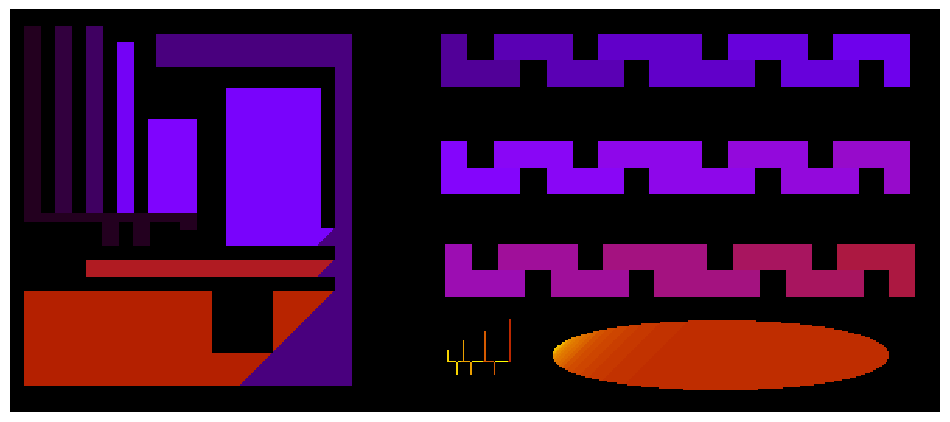

In [3]:
result_image = connected_component_labelling(ccl_image)

print("Number of labels:", result_image.max())

_, ax = plt.subplots(figsize=(12, 6))
show_grayscale_image(ax, result_image, matshow=True, cmap="gnuplot")

## Dyskusja:

- W wyniku indeksacji uzyskujemy obraz, na którym wyróżnionych jest wiele obiektów (dokładnie 48) - a faktycznie jest tylko 7. Zastanówmy się z czego to wynika.

- Zacznijmy od prostego przypadku przedstawionego na poniższym rysunku:

  ![Indeksacja - przykład pierwszy](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx1.png)

  Obraz analizowany jest linia po linii.
  Zatem pierwszą etykietę dostanie słupek po prawej.
  Późnej ten po lewej.
  Postępując zgodnie z podanym algorytmem, w pewnym momencie (piksel wyróżniony na obrazku) dojdzie do sytuacji, w której w otoczeniu danego piksela znajdą się dwie różne etykiety (tu: '1' i '2').
  Wtedy zgodnie z przyjętą metodologią przypisujemy niższą, tj. '1'.
  Problem jaki powstaje, to brak zapamiętania informacji o tym, że wystąpił taki konflikt tj. że powinno nastąpić połączenie etykiet '1' i '2'.
  Z tego powodu wynik działania algorytmu nie jest poprawny.

-  Przeanalizujmy jeszcze jeden, bardziej złożony przykład z rysunku poniżej:
   ![Indeksacja - przykład drugi](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx2.png)

   Słupek po prawej dostaje indeks '1', a po lewej '2'.
   W czwartej linii występuje piksel, który ma w swoim sąsiedztwie (A,B,C,D) same piksele czarne.
   Dlatego dostaje etykietę '3'.
   Jednak w następnym kroku okazuje się, że następuje konflikt '3' z '1' (połączenie).
   W kolejnym wierszu występuje konflikt '2' i '3'.
   Warto zwrócić uwagę, że w tym przypadku trzeba uniknąć sytuacji ''utraty'' informacji o połączeniu '1' z '2' przez '3'.

- W literaturze zaproponowano wiele sposobów reprezentacji i rozwiązywania przedstawionych konfliktów:
    - 2-krotki,
    - n-krotki,
    - tablica dwuwymiarowa,
    - grafy + przeszukiwanie grafu wgłąb.
 W obecnym ćwiczeniu zastosujemy ostatnie podejście, które jest najprostsze do realizacji.

- Opisane konflikty możemy przechowywać w strukturze zbiorów rozłącznych (ang. _union find_).
  Jest to zagadnienie znane z przedmiotu ''Algorytmy i struktury danych''.
  Poniżej zostanie zaprezentowane krótkie przypomnienie.

- Mamy $N$ obiektów. W naszym przypadku to jest $N$ etykiet.
  Chcemy przechowywać informację o sytuacji, w której następuje łączenie etykiet tj. interesują nas zbiory obiektów połączonych.
  Przykład trzech zbiorów zamieszczono na rysunku:
  ![Przykład trzech połączonych zbiorów](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/unionFind1.png)

- W ramach rozważanej struktury implementuje się dwie operacje:
    - *find* (znajdź) - sprawdzenie czy dwa obiekty należą do tego samego zbioru połączonego,
	- *union* (połącz) - wprowadź połączenie pomiędzy dwoma obiektami.

- Z punktu widzenia naszych potrzeb ważna jest funkcja _union_. Przykład dodania połączenia pomiędzy obiektami '2' a'3' pokazano na rysunku:

  ![Przykład łączenia obiektów](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/unionFind2.png)

- Strukturę oraz obie operacje można zaimplementować na kilka sposobów.
  Zainteresowanych odsyłam do literatury przedmiotu.
  My zastosujemy podejście _quick-union_.
  Nie jest ono specjalnie wydajnie, ale bardzo proste do implementacji.

- Nasz graf, w którym wierzchołki oznaczają etykiety, a krawędzie połączenia między etykietami, zapiszemy w tablicy jednowymiarowej `id[]` o rozmiarze $N$ (maksymalna liczba etykiet).
  Interpretacja pola w tablicy: `id[i]` jest rodzicem `i`.
  Korzeń elementu `i` jest dany jako: `id[id[id[...id[i]...]]]`.

- Przeanalizujmy jak to działa na prostym przykładzie.
  Mamy dany poetykietowany obraz:

    ![Indeksacja - przykład 3](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3.png)

  Występuje na nim pięć konfliktów oznaczonych A, B, C, D i E  (uwaga w trakcie działania algorytmu pojawią się właśnie w takiej kolejności).

- Sytuację wyjściową opisuje poniższy rysunek:
   ![Indeksacja - przykład 3](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3_union1.png)

   Tablica `id` wypełniona jest kolejnymi indeksami.

- W algorytmie _quick-union_, aby połączyć elementy $p$ i $q$ należy ustawić $id$ korzenia $q$ pod adres korzenia elementu $p$.
Uwaga. Zakładamy, że $p$ < $q$.
Można to zapisać jako: `id[root(p)] = root(q)`.
Nasze pierwsze połączenie (A) to 4 z 2.
Po tej operacji sytuacja będzie wyglądać następująco:

    ![Indeksacja - przykład 3_1](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3_union2.png)

W tym przypadku korzenieniem obu elementów są same elementy, zatem operacja jest dość prosta.

- Kolejny krok tj. połączenie  2 z 1 -  sytuacja B:

    ![Indeksacja - przykład 3_2](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3_union3.png)

Element 1 jest korzeniem.
Element 2 już nie, ponieważ `id[2]==4`.
Sprawdzamy zatem `id[4]`.
Okazuje się, że `id[4] == 4` tj. jest to korzeń.
Zatem korzeniem dla elementu 2 jest 4.
Dokonujemy stosownej modyfikacji w tablicy `id[1] = 4`.

-  Kolejne połączenie to 6 z 3 (C):

    ![Indeksacja - przykład 3_3](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3_union4.png)

- Kolejne połączenie to 5 z 1.

    ![Indeksacja - przykład 3_4](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3_union5.png)

Szukamy korzenia elementu 1.
Znajdujemy, że to jest 4.
Zatem łączymy 5 i 4.

- Ostatnie połączenie to 6 z 5.

   ![Indeksacja - przykład 3_5](https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/cclEx3_union6.png)

-  Ostatni krok to wykorzystanie informacji zawartej w tablicy `id` do wyznaczenia przekodowania LUT (ang. _look-up table_), które pozwoli nam nadać poprawne etykiety wszystkim pikselom.
      Zasadniczo sprowadza się on do obliczenia dla każdej możliwej etykiety jej korzenia.
      W naszym przypadku zawsze otrzymamy 6, gdyż wszystkie piksele są ze sobą połączone i stanowią jeden obiekt.

## Implementacja:

- Implementacja jest dużo prostsza i krótsza od powyższego opisu.
  Istotne jest tylko dobre zrozumienie algorytmu _union-find_.

- Potrzebne będą nam dwie funkcje pomocnicze:

    - `root` - obliczanie korzenia zgodnie z podanym opisem (odpowiednia pętla `while`). Funkcja pobiera indeks elementu oraz tablicę, a zwraca indeks korzenia.
    - `union` - realizacja operacji unii. Argumenty to indeksy `p` i `q` oraz tablica, a wyniki to zmodyfikowana tablica.

- Na początku, przed pierwszym przebiegiem algorytmu indeksacji, tworzymy tablicę `id` i inicjujemy ją wartościami od 1 do $N$.
  Dla rozważanego przykładu wystarczy $N = 100$.

- Następnie, w przypadku wystąpienia konfliktu (przypadek ()c)), tworzymy unię pomiędzy etykietą mniejszą i większą.

- Po pierwszym przebiegu tworzymy, w opisany powyżej sposób, przekodowanie LUT (pętla po `id` i funkcja `root`). Powstaje nam tablica `lut`.

- Implementujemy drugi przebieg po obrazie.
  Jest on bardzo prosty.
  Dla każdego piksela, który nie jest tłem (o etykiecie większej od 0) realizujemy przekodowanie LUT (`lut_table[img[j, i] - 1]`).
  Otrzymany w ten sposób obraz wyświetlamy.
  Powinniśmy uzyskać poprawne etykietowanie.

In [4]:
from collections import deque


class UnionFind:
    def __init__(self) -> None:
        # Graph - each label has a list of connected labels
        self.__graph = {}
        self.__roots = None

    def add_label(self) -> int:
        new_label = len(self.__graph) + 1
        self.__graph[new_label] = []

        return new_label

    def make_union(self, p: int, q: int) -> None:
        self.__graph[p].append(q)
        self.__graph[q].append(p)

    def get_root(self, p: int) -> int:
        assert self.__roots is not None, "Execute `.calculate()` before accessing roots"

        return self.__roots[p]

    def calculate(self) -> None:
        roots = {label: None for label in self.__graph.keys()}

        current_root_label = 1
        for label in self.__graph.keys():
            if roots[label] is not None:
                continue

            neighbours = self.__bfs(label)
            for neighbour in neighbours:
                roots[neighbour] = current_root_label
            current_root_label += 1

        self.__roots = roots

    def __bfs(self, starting_label: int) -> list[int]:
        queue = deque()
        queue.append(starting_label)

        visited = {label: False for label in self.__graph.keys()}
        result = []

        while len(queue) > 0:
            label = queue.popleft()
            if visited[label]:
                continue

            visited[label] = True
            result.append(label)
            for neighbour in self.__graph[label]:
                if not visited[neighbour]:
                    queue.append(neighbour)

        return result


def fixed_ccl(image):
    height, width = image.shape
    result_img = np.zeros(shape=image.shape, dtype=np.uint8)
    union_find = UnionFind()

    for y in range(1, height):
        for x in range(1, width - 1):
            if image[y, x] == 0:
                continue

            delta_indexes = [
                (dy, dx)
                for dy in [-1, 0]
                for dx in [-1, 0, 1]
                if dy < 0 or dy == 0 and dx < 0
            ]
            indexes = [(y + dy, x + dx) for (dy, dx) in delta_indexes]

            neighbour_labels = [
                result_img[y2, x2] for (y2, x2) in indexes if result_img[y2, x2] > 0
            ]

            # New label
            if len(neighbour_labels) == 0:
                new_label = union_find.add_label()
                result_img[y, x] = new_label

            # One neighbour
            elif min(neighbour_labels) == max(neighbour_labels):
                result_img[y, x] = neighbour_labels[0]

            # Two neighbours
            else:
                label1, label2 = min(neighbour_labels), max(neighbour_labels)
                union_find.make_union(label1, label2)

                result_img[y, x] = label1

    union_find.calculate()

    for y in range(height):
        for x in range(width):
            if result_img[y, x] == 0:
                continue

            result_img[y, x] = union_find.get_root(result_img[y, x])

    return result_img

Number of labels: 7


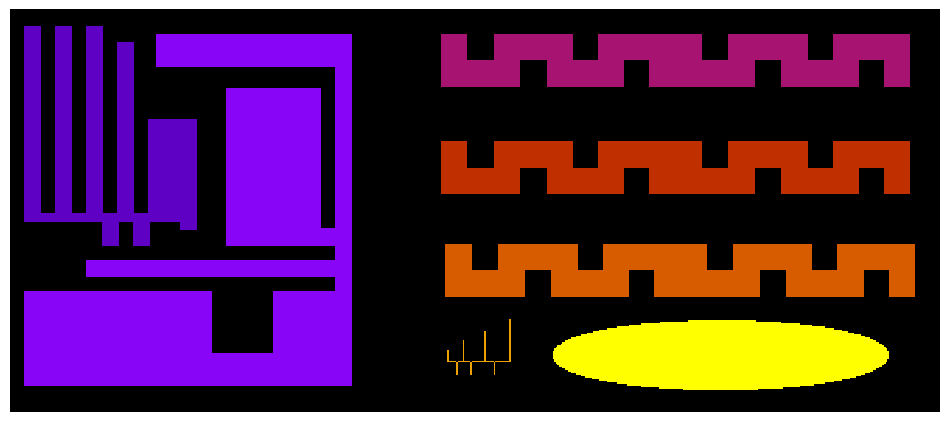

In [5]:
result_image = fixed_ccl(ccl_image)

print("Number of labels:", result_image.max())

_, ax = plt.subplots(figsize=(12, 6))
show_grayscale_image(ax, result_image, matshow=True, cmap="gnuplot")

## Indeksacja wbudowana w OpenCV

W OpenCV dostępna jest funkcja `connectedComponents`, która pozwala wykonać indeksację.
Proszę sprawdzić jej działanie na używanym wcześniej obrazie.

Number of labels: 7


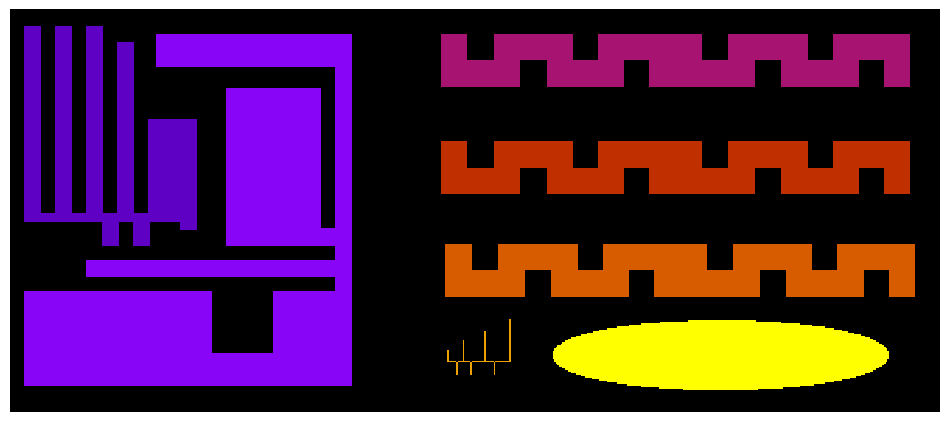

In [6]:
_, result_image = cv2.connectedComponents(ccl_image)

print("Number of labels:", result_image.max())

_, ax = plt.subplots(figsize=(12, 6))
show_grayscale_image(ax, result_image, matshow=True, cmap="gnuplot")

## Rozpoznawanie obiektów z wykorzystaniem współczynników kształtu

Współczynniki kształtu są pewnymi parametrami liczbowymi opisującymi kształt obiektu.
Pozwala to na użycie ich do automatycznego rozpoznawania obiektów.
Teoretycznie współczynniki kształtu (dobre) powinny być niezależne od zmiany położenia obiektu, jego orientacji i wielkości.
W praktyce okazuje się jednak, że wartości współczynników zmieniają się w pewnym zakresie nawet dla obiektów należących do tych samych klas (te same kształty - przykład obracany kwadrat).
Wynika z tego konieczność uwzględnienia pewnej tolerancji wartości współczynników kształtu wykorzystywanych w praktycznych zastosowaniach analizy i rozpoznawania obrazu.

# Implementacja dla obrazu sztucznego

- Wczytaj obraz _shapes.png_.
  Wyświetl go.
  Pierwszym etapem zadania będzie wybranie współczynników kształtu i przedziałów ich wartości - takich, które pozwolą na wykrycie konkretnych kształtów.
  Do wyboru jest kwadrat lub krzyżyk (koło jest zbyt łatwe).

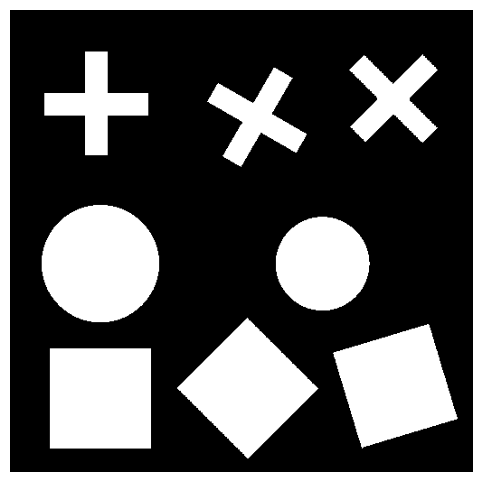

In [7]:
shapes_image = cv2.imread(SHAPES_FILENAME, flags=cv2.IMREAD_GRAYSCALE)

_, ax = plt.subplots(figsize=(12, 6))
show_grayscale_image(ax, shapes_image, matshow=False)

- Obok ''klasycznych'' współczynników kształtu tj. Blair-Bliss, Malinowskiej, Haralick, występują współczynniki będące pochodnymi momentów geometrycznych tzn. momenty Hu [https://en.wikipedia.org/wiki/Image_moment]. Wykorzystamy je w naszym ćwiczeniu.

- Pierwszy krok to indeksacja obrazu - poznana funkcja `connectedComponents`.
- Następnie w pętli, dla kolejnych obiektów wyznaczamy współczynniki Hu.
    - po pierwsze należy ''wybrać'' z obrazu dany obiekt np. `I = (ccl == s)*1` oraz `I = I.astype('uint8')`
    - po drugie obliczyć momenty geometryczne - `cv2.moments(I)`
    - po trzecie, na podstawie momentów, obliczyć momentu Hu `cv2.HuMoments(moments)`
- Mając wyznaczone współczynniki musimy jest przeanalizować. W tym celu dobrze ja jakoś wyświetlić w postaci macierzy - proszę to rozwiązać samodzielnie.

- Na podstawie analizy należy wybrać próg (jeden lub więcej) i zrealizować stosowną filtrację tj. usunąć ''niechciane'' kształty.

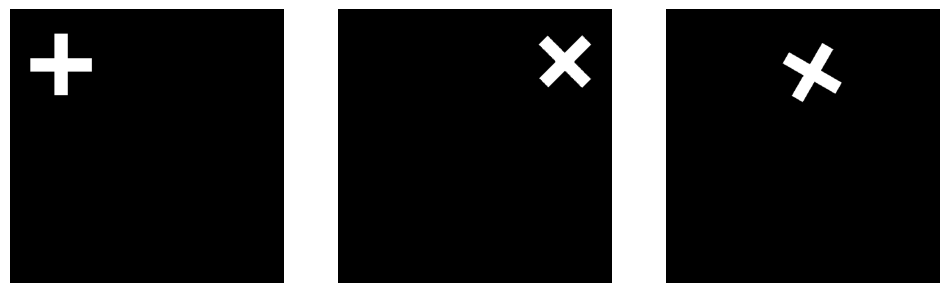

[[ 2.50203915e-01  2.57949086e-01  2.57059062e-01]
 [ 2.30928490e-09  1.08977954e-06  1.50261870e-07]
 [ 2.31959783e-05  2.86216549e-05  2.73926132e-05]
 [ 1.47326898e-06  1.77622893e-06  1.73732679e-06]
 [ 8.61250351e-12  1.26306067e-11  1.19840998e-11]
 [ 7.07979694e-11 -1.85400651e-09 -6.73378794e-10]
 [ 1.18247860e-24  9.29001241e-13 -1.49054457e-13]]


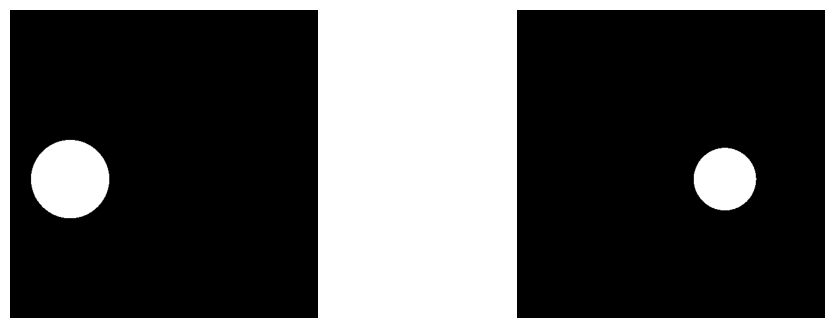

[[ 1.59154823e-01  1.59155875e-01]
 [ 3.16293019e-08  1.30608986e-07]
 [ 8.22063073e-10  9.50757712e-09]
 [ 7.36340232e-14  3.34678824e-13]
 [-3.49346145e-25 -1.33716847e-24]
 [ 1.15762233e-17 -5.82882780e-17]
 [ 4.54047242e-25  1.88315114e-23]]


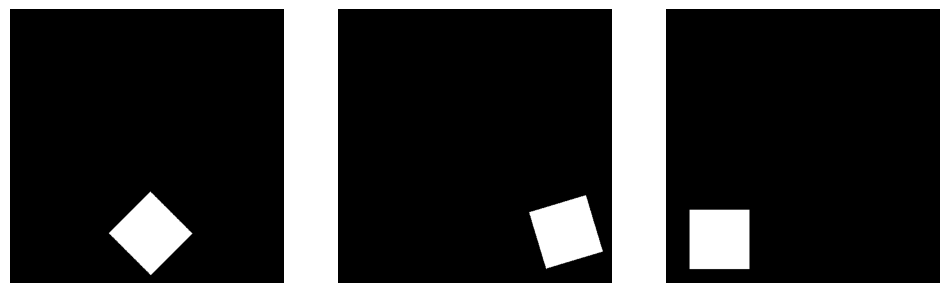

[[ 1.66692179e-01  1.66718427e-01  1.66659964e-01]
 [ 2.37382411e-06  1.50054250e-06  2.23442217e-06]
 [ 6.35596477e-10  2.85079199e-09  0.00000000e+00]
 [ 5.31257419e-11  1.86840551e-10  0.00000000e+00]
 [ 4.01564382e-21  1.08808452e-19  0.00000000e+00]
 [-5.99781460e-14 -6.24180205e-15  0.00000000e+00]
 [-8.89805573e-21  8.21887030e-20  0.00000000e+00]]


In [8]:
def indexed_image_into_object_images(number_of_labels: int, indexed_image) -> list:
    result = []
    for i in range(1, number_of_labels):
        object_image = (indexed_image == i).astype(np.uint8)

        object_moments = cv2.moments(object_image)
        hu_moments = cv2.HuMoments(object_moments)

        result.append((hu_moments, object_image))

    return result


def detect_objects(image) -> list[tuple]:
    number_of_labels, indexed_image = cv2.connectedComponents(image)

    return indexed_image_into_object_images(number_of_labels, indexed_image)


detected_objects = detect_objects(shapes_image)
crosses = detected_objects[:3]
circles = detected_objects[3:5]
squares = detected_objects[5:]

for shape in [crosses, circles, squares]:
    _, axs = plt.subplots(ncols=len(shape), figsize=(12, 4))
    for ax, (_, image) in zip(axs, shape):
        show_grayscale_image(ax, image)

    plt.show()
    print(np.array([moments[:, 0] for (moments, _) in shape]).T)

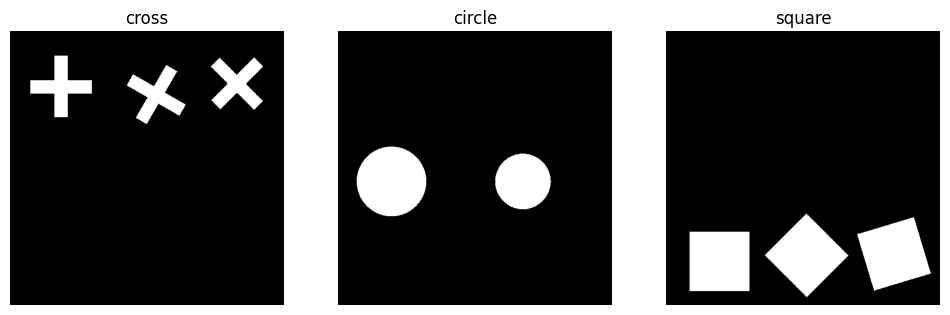

In [9]:
def clasify_shape(hu_moments):
    RELATIVE_TOLERANCE = 0.01

    if np.isclose(hu_moments[0, 0], 0.167, rtol=RELATIVE_TOLERANCE):
        return "square"

    if np.isclose(hu_moments[0, 0], 0.159, rtol=RELATIVE_TOLERANCE):
        return "circle"

    return "cross"


classified_shapes = {}
for hu_moments, object_image in detect_objects(shapes_image):
    label = clasify_shape(hu_moments)

    current_list = classified_shapes.get(label)
    classified_shapes[label] = (current_list if current_list is not None else []) + [
        object_image
    ]

fig, axs = plt.subplots(ncols=len(classified_shapes), figsize=(12, 4))

for ax, (label, images) in zip(axs, classified_shapes.items()):
    merged_image = sum(images)

    show_grayscale_image(ax, merged_image, title=label)

# Implementacja dla obrazu rzeczywistego

- Podobne ćwiczenie należy zrealizować dla obrazu rzeczywistego _shapesReal.png_.

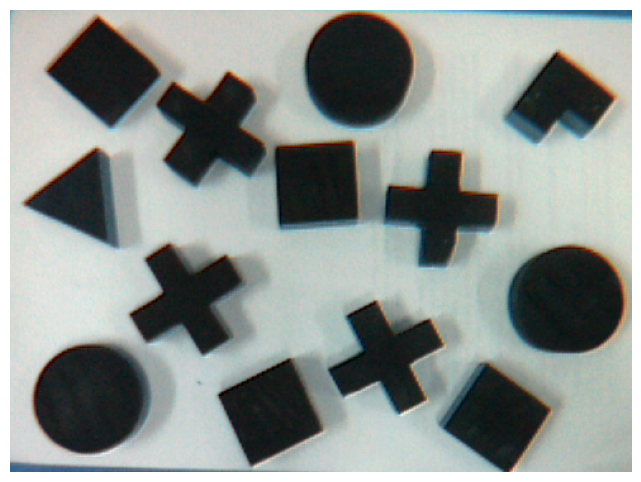

In [10]:
shapes_real_image = cv2.imread(SHAPES_REAL_FILENAME)

_, ax = plt.subplots(figsize=(12, 6))
show_grayscale_image(ax, shapes_real_image)

- Uwaga. Wykorzystując poznane metody przetwarzania obrazu doprowadź obraz do postaci binarnej (usuń ew. zakłócenia itp.).

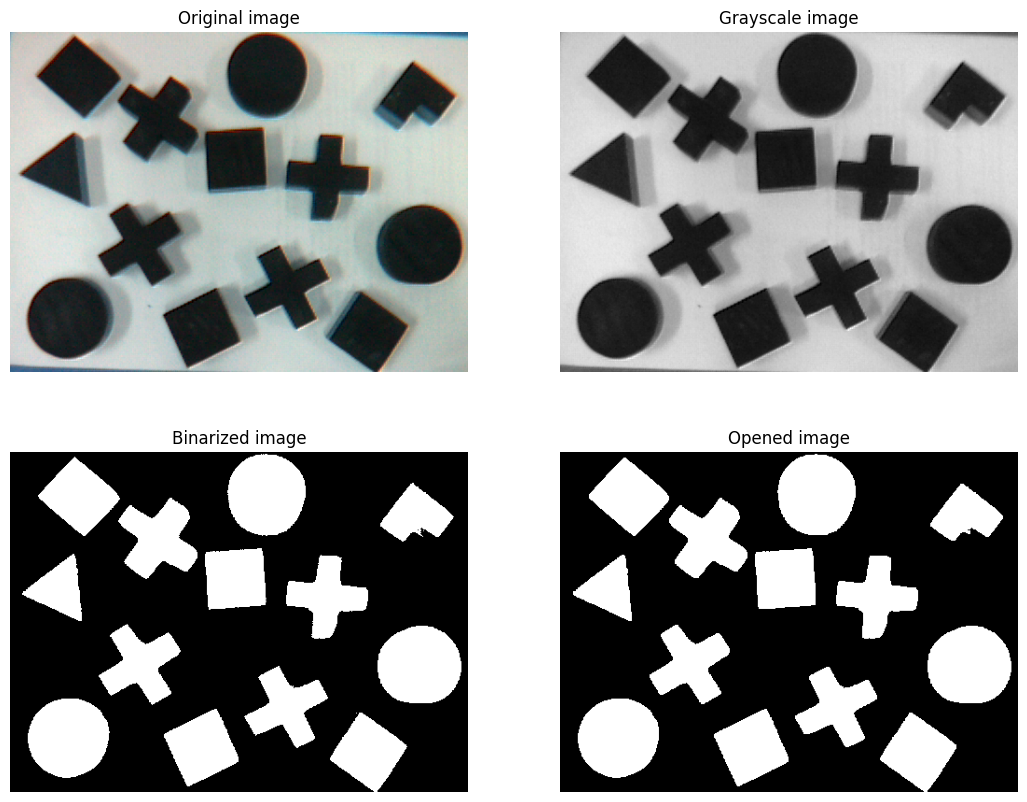

In [11]:
BINARIZATION_THRESHOLD = 70
KERNEL_SIZE = 3
ITERATIONS = 1

shapes_grayscale = cv2.cvtColor(shapes_real_image, code=cv2.COLOR_RGB2GRAY)
shapes_binarized = (shapes_grayscale < BINARIZATION_THRESHOLD).astype(np.uint8)
kernel = np.ones((KERNEL_SIZE, KERNEL_SIZE), np.uint8)
shapes_eroded = cv2.erode(shapes_binarized, kernel, iterations=ITERATIONS)
shapes_opened = cv2.dilate(shapes_eroded, kernel, iterations=ITERATIONS)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))

for ax, (title, image) in zip(
    [ax for row in axs for ax in row],
    [
        ("Original image", shapes_real_image),
        ("Grayscale image", shapes_grayscale),
        ("Binarized image", shapes_binarized),
        ("Opened image", shapes_opened),
    ],
):
    show_grayscale_image(ax, image, title)

- Uwagi:
    - należy z obrazu wyeliminować małe grupki pikseli - tak aby nie zostały poindeksowane,
    - obiektów powinno być 13,
    - może się okazać, że zajdzie potrzeba modyfikacji warunków na współczynniki albo wręcz wprowadzenia dodatkowych współczynników.
    - warto zaznaczyć, że opisane podejście tj. ''ręczne'' wyznaczanie przedziałów parametrów stosuje się tylko do bardzo prostych problemów. W rzeczywistych aplikacjach rozpoznawania obrazu stosuje się tzw. uczenie maszynowe i klasyfikatory typu sztuczne sieci neuronowe, algorytm k-NN, czy SVM.

- Sposób postępowania jest zasadniczo bardzo podobny do tego użytego wcześniej. Przy czym, ponieważ obiektów jest więcej, warto je sobie ''opisać'' - ułatwia to analizę:
    - użyjemy funkcji `connectedComponentsWithStats` - pozwala ona wyliczyć statystyki (pole, prostokąt otaczający oraz centroid). Szczegóły użycia proszę sprawdzić w dokumentacji,
    - wykonujemy kopię obrazu poindeksowanego (`ccl_vis = ccl.copy()`),
    - w pętli po obiektach wypisujemy numery:
      `cv2.putText(ccl_vis,str(label_num),(int(centroids[s,0]),int(centroids[s,1])),cv2.FONT_HERSHEY_SIMPLEX,1,(20,0,0),2)`
      Argumenty to odpowiednio: obraz, tekst, jego położenie, czcionka, rozmiar, kolor, grubość).
      Zwracam uwagę na kolor, tu dobrze jest dać wartość nieco większą niż maksymalna etykieta.
      Inaczej wystąpi problem z czytelnością wizualizacji.

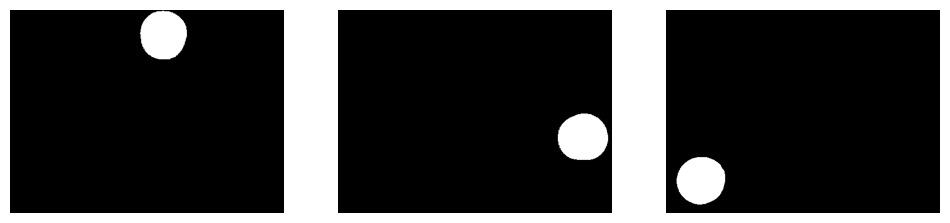

Hu Moments:
[[ 1.59460498e-01  1.59764483e-01  1.59352198e-01]
 [ 5.83728970e-05  1.50618510e-04  4.89707874e-05]
 [ 4.57858916e-06  6.55701959e-06  2.37447216e-06]
 [ 2.19905980e-09  1.29459360e-08  1.89941001e-09]
 [ 1.66080239e-16 -1.90509998e-15  1.27548994e-16]
 [ 1.50006799e-11 -5.57152388e-11  1.32330277e-11]
 [ 1.45284868e-16  3.25536200e-15 -1.60983282e-18]]


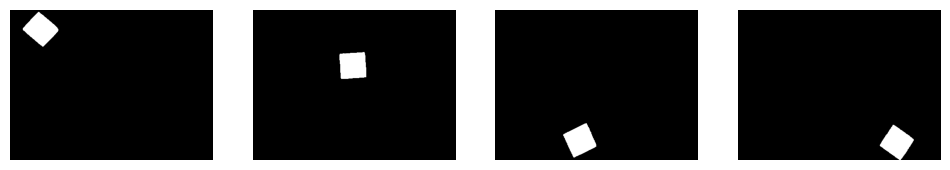

Hu Moments:
[[ 1.66894677e-01  1.66294777e-01  1.66218203e-01  1.65987947e-01]
 [ 5.22849511e-04  9.76136080e-06  4.23663665e-05  6.07330817e-05]
 [ 2.04631663e-07  6.04827826e-07  1.19259553e-06  3.57629720e-07]
 [ 3.40441249e-08  2.33879020e-08  3.07219217e-08  2.07331429e-08]
 [ 2.08288502e-15  8.50045337e-16 -5.12415386e-15 -1.44726521e-15]
 [ 3.07154359e-10  1.22579991e-11 -1.44679459e-10  7.98646823e-11]
 [-1.93281850e-15  2.64858644e-15 -2.88515306e-15 -1.04535548e-15]]


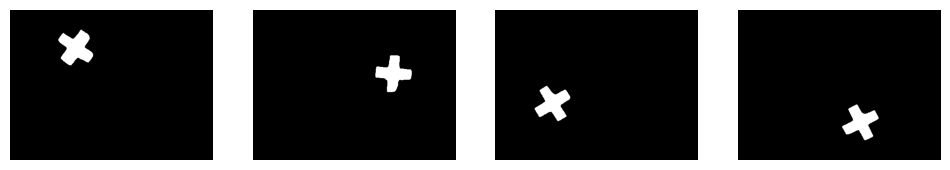

Hu Moments:
[[ 1.92092254e-01  2.00298823e-01  2.04413014e-01  2.05565242e-01]
 [ 1.78055215e-05  1.25908485e-05  6.90606660e-05  6.05849608e-06]
 [ 2.74014197e-06  7.46961733e-06  1.15904113e-05  1.26290779e-05]
 [ 1.85943769e-06  6.68220921e-08  7.79589313e-07  1.52235060e-06]
 [-5.50203127e-13 -2.19091450e-14 -8.82861080e-13 -4.32220385e-12]
 [ 7.41564107e-09  2.15167710e-10  6.14955430e-09 -4.72460784e-10]
 [ 4.16097449e-12  4.18177596e-14  2.17074313e-12  5.08679940e-12]]


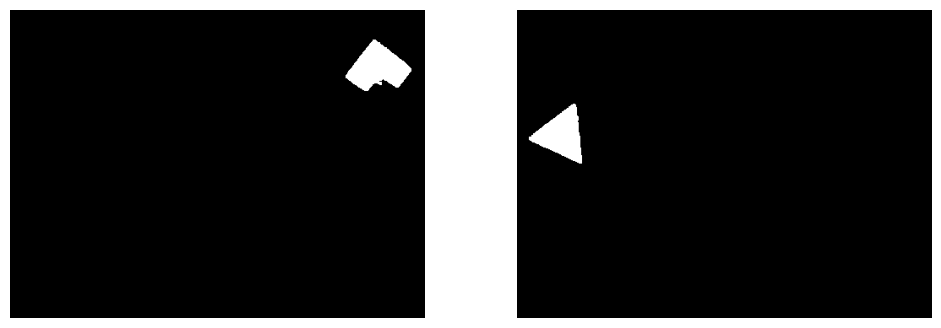

Hu Moments:
[[ 1.83783360e-01  1.90102486e-01]
 [ 3.21270534e-03  5.35302979e-05]
 [ 1.30891850e-03  4.12384904e-03]
 [ 2.37973020e-05  1.62363799e-06]
 [-3.83098814e-09 -1.02525173e-10]
 [-1.27158572e-06 -1.09710767e-08]
 [-1.72145746e-09  8.44963415e-11]]


In [12]:
number_of_labels, indexed_image, frames, centroids = cv2.connectedComponentsWithStats(
    shapes_opened
)

# detected_objects = [image for _, image in indexed_image_into_object_images(number_of_labels, indexed_image)]
detected_objects = indexed_image_into_object_images(number_of_labels, indexed_image)

circles = [0, 8, 10]
squares = [1, 4, 11, 12]
crosses = [3, 6, 7, 9]
other = [2, 5]

circles, squares, crosses, other = [
    [
        (detected_objects[index][0], detected_objects[index][1])
        for index in shapes_indexes
    ]
    for shapes_indexes in [circles, squares, crosses, other]
]

for shape in [circles, squares, crosses, other]:
    _, axs = plt.subplots(ncols=len(shape), figsize=(12, 4))
    for ax, (hu_moments, image) in zip(axs, shape):
        show_grayscale_image(ax, image)

    plt.show()
    # object_moments = [cv2.moments(image) for (image, _, _) in shape]
    # hu_moments = [cv2.HuMoments(moment) for moment in object_moments]

    print("Hu Moments:")
    print(np.array([hu_moments[:, 0] for (hu_moments, _) in shape]).T)
    # print(np.array([moments[:, 0] for moments in hu_moments]).T, end="\n\n")

    # print("Frames:")
    # print(np.array([frame for (_, frame, _) in shape]).T, end="\n\n")

    # print("Centroids:")
    # print(np.array([centroid for (_, _, centroid) in shape]).T)

- Przeprowadzamy podobną analizę jak wcześniej i dobieramy odpowiednie warunki/progi.

In [13]:
def clasify_real_shape(hu_moments):
    # print(hu_moments)
    RELATIVE_TOLERANCE = 0.01

    if np.isclose(hu_moments[0], 0.159, rtol=RELATIVE_TOLERANCE):
        return "circle"

    if np.isclose(hu_moments[0], 0.166, rtol=RELATIVE_TOLERANCE):
        return "square"

    if np.isclose(hu_moments[0], 0.2, rtol=0.08) and hu_moments[6] < 1e-11:
        return "cross"

    return "?"

- W efekcie powinniśmy uzyskać obraz z krzyżykami, kwadratami lub kółkami.

(-0.5, 490.5, 364.5, -0.5)

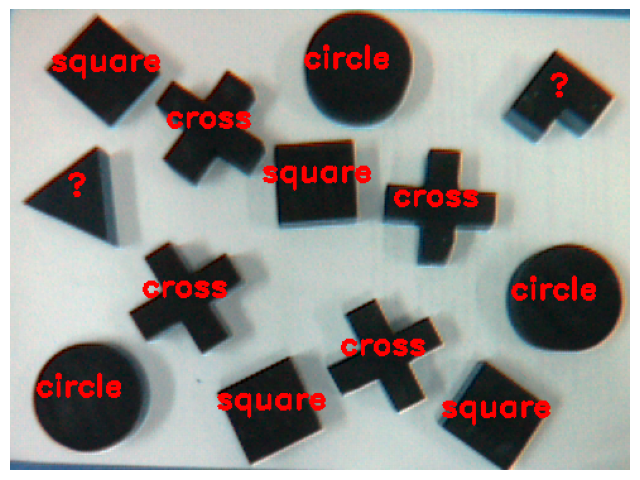

In [14]:
labeled_image = shapes_real_image.copy()
labels = [clasify_real_shape(hu_moments[:, 0]) for (hu_moments, _) in detected_objects]

for i, (label, (_, img)) in enumerate(zip(labels, detected_objects), start=1):
    frame = frames[i, :]
    centroid = centroids[i, :]

    cv2.putText(
        labeled_image,
        text=label,
        org=(int(centroid[0]) - 7 * len(label), int(centroid[1])),
        fontFace=cv2.FONT_HERSHEY_DUPLEX,
        fontScale=0.8,
        thickness=2,
        color=(255, 0, 0),
    )

_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(labeled_image)
ax.axis("off")